In [430]:
import cv2
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import random as rng
import math
from numpy import ones,vstack
from numpy.linalg import lstsq


In [431]:
def adjust_gamma(image, gamma=1.0):
    invGamma = 1.0 / gamma
    table = np.array([((i / 255.0) ** invGamma) * 255
        for i in np.arange(0, 256)]).astype("uint8")
    return cv2.LUT(image, table)

def gaussian_blur(img, kernel_size):
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def to_hls(img):
    return cv2.cvtColor(img, cv2.COLOR_BGR2HLS)

def to_hsv(img):
    return cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

def grayscale(img):
    return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

def warp_perspective(img,mat):
    return cv2.warpPerspective(img ,mat ,(1280,720))
    
def PerspectiveTransform(src,dst):
    mat = cv2.getPerspectiveTransform(src,dst)
    mat_inv = cv2.getPerspectiveTransform(dst,src)
    return mat,mat_inv

def isolate_color_mask(img, low_thresh, high_thresh):
    return cv2.inRange(img, low_thresh, high_thresh)


def draw_lines(img, lines, color=[255, 0, 0], thickness=4):
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)
    return img


def concat_frames(frames):
    
    scale_percent = 0.2
    height = int(frames[0].shape[0] * 0.5)
    width = int(frames[0].shape[1] * scale_percent)
    dim = (width, height)
    img = cv2.resize(frames[0], dim, interpolation = cv2.INTER_AREA)
    img2= cv2.resize(cv2.cvtColor(frames[5], cv2.COLOR_GRAY2BGR), dim, interpolation = cv2.INTER_AREA)
        
    for i in range(1,len(frames)):
        try:
            frames[i] = cv2.cvtColor(frames[i], cv2.COLOR_GRAY2BGR)
        except:
            pass
        
        if(i==5):
            continue
        
        try:
            resized = cv2.resize(frames[i], dim, interpolation = cv2.INTER_AREA)
            if i< (len(frames)/2):
                img = cv2.hconcat([img,resized])
            else:
                img2 = cv2.hconcat([img2,resized])
        except:
            pass
    
    t = cv2.vconcat([img,img2])
            
            

            
    
    return t


def get_right(image):
    cropped_img=np.zeros_like(image)
    cropped_img[:,image.shape[1]//2:image.shape[1]] = image[:,image.shape[1]//2:image.shape[1]]
    return cropped_img

def get_third_right(image):
    cropped_img=np.zeros_like(image)
    cropped_img[:,image.shape[1]*2//3:image.shape[1]] = image[:,image.shape[1]*2//3:image.shape[1]]
    return cropped_img

def get_left(image):
    cropped_img=np.zeros_like(image)
    cropped_img[:,0:image.shape[1]//2] = image[:,0:image.shape[1]//2]
    return cropped_img

def get_third_left(image):
    cropped_img=np.zeros_like(image)
    cropped_img[:,0:image.shape[1]//3] = image[:,0:image.shape[1]//3]
    return cropped_img

def calculateDistance(x1,y1,x2,y2):
    dist = math.sqrt((x2 - x1)**2 + (y2 - y1)**2)
    return dist
        


def get_aoi(img):
    rows, cols = img.shape[:2]
    mask = np.zeros_like(img)
    
    left_bottom = [cols * 0.1, rows]
    right_bottom = [cols * 0.95, rows]
    left_top = [cols * 0.4, rows * 0.6]
    right_top = [cols * 0.6, rows * 0.6]
    
    vertices = np.array([[left_bottom, left_top, right_top, right_bottom]], dtype=np.int32)
    
    if len(mask.shape) == 2:
        cv2.fillPoly(mask, vertices, 255)
    else:
        cv2.fillPoly(mask, vertices, (255, ) * mask.shape[2])
    return cv2.bitwise_and(img, mask)
    

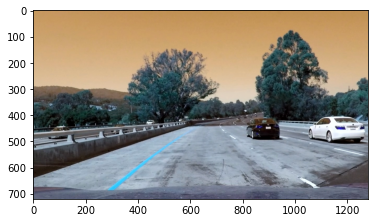

In [432]:
img=cv2.imread(r"Assets\Project_data\test_images\test1.jpg")


rows, cols = img.shape[:2]
mask = np.zeros_like(img)

input_top_left = [500,480]
input_top_right = [780,480]
input_bottom_right = [1200,700]
input_bottom_left = [170,700]
srcPts = np.float32([input_bottom_left,input_top_left,input_top_right,input_bottom_right])
dstPts = np.float32([[0,720],[0,0],[1280,0],[1280,720]])

plt.imshow(img)



In [433]:
left = tuple()
right = tuple()
top = tuple()
bottom = tuple()

old_j=0,0
old_i=0,0
old_jr=0,0
old_ir=0,0
old_centr=0,0
old_contour=[]
old_contour_w=[]


arr=list()
for i in range(4):
    arr.append([])

old_pts=[]

In [434]:

cap = cv2.VideoCapture(r"Assets\Project_data\project_video.mp4")

counter = 0
y=0
while cap.isOpened():
  ret,img = cap.read()
  if not ret:
      break
  
  me=(img.shape[1]//2,img.shape[0]//2)
  
  # cv2.line(img,(me[0],0),(me[0],720),(0,0,255),3) #dashed
  mat,mat_inv = PerspectiveTransform(srcPts,dstPts)
  
  
  p = me[0],600 # your original point
  px = (mat[0][0]*p[0] + mat[0][1]*p[1] + mat[0][2]) / ((mat[2][0]*p[0] + mat[2][1]*p[1] + mat[2][2]))
  py = (mat[1][0]*p[0] + mat[1][1]*p[1] + mat[1][2]) / ((mat[2][0]*p[0] + mat[2][1]*p[1] + mat[2][2]))
  me = (int(px), int(py)) # after transformation
  
  bird_view = warp_perspective(img,mat)
  bird_cpy = bird_view.copy()
  
  cv2.circle(bird_cpy,me,5,(255,255,0),10)
  
  gray_img = grayscale(bird_view)
  darkened_img = adjust_gamma(gray_img, 0.5)
  white_mask = isolate_color_mask(to_hls(bird_view), np.array([0, 200, 0], dtype=np.uint8), np.array([200, 255, 255], dtype=np.uint8))
  yellow_mask = isolate_color_mask(to_hls(bird_view), np.array([10, 0, 100], dtype=np.uint8), np.array([40, 255, 255], dtype=np.uint8))
  mask = cv2.bitwise_or(white_mask, yellow_mask)
  colored_img = cv2.bitwise_and(darkened_img, darkened_img, mask=mask)
  blurred_img = gaussian_blur(colored_img, kernel_size=7)
  edges = cv2.Canny(mask,70,140)
  edges = cv2.dilate(edges,np.ones((9,9)))  
  
  contours,_= cv2.findContours(get_third_left(edges), cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
  
  
  try:
    c = max(contours, key=cv2.contourArea)
    old_contour_w=c
  except:
    c=old_contour_w

  
  left = tuple(c[c[:, :, 0].argmin()][0])
  right = tuple(c[c[:, :, 0].argmax()][0])
  top = tuple(c[c[:, :, 1].argmin()][0])
  bottom = left[0] + right[0]-top[0] , left[1]
  points = np.array([bottom,right,top,left])
  
  for i,p in enumerate(points) :
    arr[i].append(p)
    
  
  
  if counter==0 :
    old_pts = points

  
  if right[1] > 1.2*36 :
      points[1]= old_pts[1]
      right= old_pts[1]
  else:
      old_pts[1]=right
      
  if left[0] > 1.2*80 or left[1] > 720 :
    points[3]= old_pts[3]
    left= old_pts[3]
  else:
    old_pts[3]=left
    
    
    
  # for p in points : 
  #   cv2.circle(bird_cpy,p,5,(255,255,0),-1)
  
    
    
    
    
  j =  (right[0]+top[0])//2,right[1]
  i =  (bottom[0]+left[0])//2, bottom[1]
  
  if counter>10 :
    
    if (calculateDistance(i[0],i[1],old_i[0],old_i[1]) > 200 and old_i!=(0,0)) or (calculateDistance(j[0],j[1],old_j[0],old_j[1]) > 200 and old_j!=(0,0)):
      j = old_j
      i = old_i
    else:
      old_i=i
      old_j=j

  
  
  
  
  
  points = [i,j]
  x_coords, y_coords = zip(*points)
  A = vstack([x_coords,ones(len(x_coords))]).T
  m, c_l = lstsq(A, y_coords)[0]
  
  j_l = 1500, int(1500*m + c_l)
  i_l = 0, int(0*m + c_l)
  

  
  cv2.line(bird_cpy,i_l,j_l,(0,0,255),40)
  
  cv2.line(bird_cpy,i,(i[0],0),(0,0,255),3) #dashed
  
  p=i
  
  
  
  contours,_= cv2.findContours(get_third_right(edges), cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
  
  for c in contours :
    rect = cv2.boundingRect(c)
    x,y,w,h = rect
    cv2.rectangle(bird_cpy,(x,y),(x+w,y+h),(0,255,0),-1)
    
  
  
  try:
    c = max(contours, key=cv2.contourArea)
    old_contour_w=c
  except:
    c=old_contour_w
  
  # rect = cv2.boundingRect(c)
  # x,y,w,h = rect
  # cv2.rectangle(bird_cpy,(x,y),(x+w,y+h),(0,255,0),-1)
  
  
  

  
  centr = x,y+h//2
  
  if calculateDistance(centr[0],centr[1],old_centr[0],old_centr[1])>50 and old_centr!=(0,0) :
    centr=old_centr
  else:
    old_centr=centr
    
  
  
  
  centr2 = int((centr[1]-c_l)/m) , centr[1]
  
  
  
  
  # centr3=(bird_cpy.shape[1]//2,bird_cpy.shape[0]//2)
  centr4=(centr2[0]+centr[0])//2,(centr2[1]+centr[1])//2
  
  # cv2.line(bird_cpy,(centr4[0],0),(centr4[0],1000),(0,0,255),3)
  cv2.line(bird_cpy,(centr[0],0),(centr[0],720),(0,0,255),3) #dashed
  
  
  

  

  
  
  

  
    
  
  r_left = tuple(c[c[:, :, 0].argmin()][0]) # top left
  r_right = tuple(c[c[:, :, 0].argmax()][0]) # bottom right
  r_top = r_right[0],r_left[1] # top right
  r_bottom = tuple(c[c[:, :, 1].argmax()][0]) # bottom left
  
  j =  (r_left[0]+r_top[0])//2,max(r_top[1], r_left[1])
  i =  (r_bottom[0]+r_right[0])//2,max(r_right[1], r_bottom[1])
  
  
  
  
  
  points = np.array([r_bottom,r_right,r_top,r_left])
  
    
  RL_U = (centr[0],0)
  RL_D = (centr[0],720)
  
  
  pts=np.array([RL_U,RL_D,i_l,j_l])
  
  


    
  # cv2.fillConvexPoly(bird_cpy, pts,color=(255, 0, 0))

  # cv2.line(bird_cpy,centr,centr2,(0,0,255),20)
  cv2.line(bird_cpy,p,(centr[0],p[1]),(0,0,255),20)
  
  centreOfLane = ((p[0]+centr[0])//2,p[1])
  
  # cv2.circle(bird_cpy,centreOfLane,5,(255,255,0),4)
  
  
  dist = np.abs(centreOfLane[0]-me[0])
  dist2=np.abs(p[0]-centr[0])
  scale = dist2/300


  text = "Distance : "  + str(int(dist*(1/scale))) + "cm."
  
  # cv2.circle(bird_cpy,((centr2[0]+centr[0])//2,(centr2[1]+centr[1])//2),5,(255,0,0),4)

  # cv2.circle(bird_cpy,(bird_cpy.shape[1]//2,bird_cpy.shape[0]//2),5,(255,255,0),4)
  cv2.putText(img=bird_cpy, text=text, org=(400, 400), fontFace=cv2.FONT_HERSHEY_TRIPLEX, fontScale=2, color=(0, 255, 0),thickness=5)
  
  

  
  

  re_gen = warp_perspective(bird_cpy,mat_inv)
  
  # cv2.imshow("fgg",re_gen)
  
  
  
  imgg = img.copy()
  cv2.addWeighted(img, 0.5, re_gen, 0.5,0, imgg)
  pipeline=[img,bird_cpy,gray_img,darkened_img,mask,colored_img,blurred_img,edges,bird_view,imgg]
  
  t=concat_frames(pipeline)
  
  counter+=1
  
  cv2.imshow("fgg",imgg)
  

    
  if cv2.waitKey(25) & 0xFF == ord('q'):
    break

cap.release()
cv2.destroyAllWindows()


C:\Users\amrhe\anaconda3\envs\MLenv\lib\site-packages\ipykernel_launcher.py:102: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


In [435]:
# # plt.plot([pts[1] for pts in old_pts])


# med=np.mean([pts[2][0] for pts in old_pts])
# print(med)


medx = np.mean([ar[0] for ar in arr[0]])
medy= np.mean([ar[1] for ar in arr[0]])
medk = np.mean([ar[1] for ar in arr[1]])
print(medx)
print(medy)
print(medk)

170.6952380952381
689.8968253968254
23.26746031746032
